[ 0.8360188   0.11314284  0.05083836]


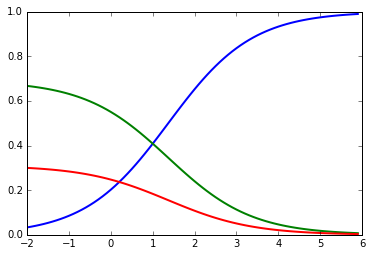

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt


"""Softmax."""

scores = [3.0, 1.0, 0.2]

import numpy as np

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    #pass  # TODO: Compute and return softmax(x)
    return np.exp(x)/np.sum(np.exp(x), axis=0)

print(softmax(scores))

# Plot softmax curves
x = np.arange(-2.0, 6.0, 0.1)
scores = np.vstack([x, np.ones_like(x), 0.2 * np.ones_like(x)])

plt.plot(x, softmax(scores).T, linewidth=2)

plt.show()

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_string('vocab', '/home/gezi/temp/textsum/tfrecord/seq-basic.10w/train/vocab.txt', 'vocabulary file')

import sys, os, math
import gezi, melt
import numpy as np

from deepiu.util import text2ids

try:
    import conf  
    from conf import TEXT_MAX_WORDS, INPUT_TEXT_MAX_WORDS
except Exception:
    TEXT_MAX_WORDS = 20
    INPUT_TEXT_MAX_WORDS = 20
    
decode_max_words = 10

tensorflow_version: 1.0.1


In [3]:
def _text2ids(text, max_words):
  word_ids = text2ids.text2ids(text, 
                               seg_method='basic', 
                               feed_single=True, 
                               allow_all_zero=True, 
                               pad=False)
  word_ids = word_ids[:max_words]
  word_ids = gezi.pad(word_ids, max_words, 0)

  return word_ids

In [4]:
from libgezi import utf82gbk, gbk2utf8
def predict(predictor, input_text):
  input_text = utf82gbk(input_text)
  word_ids = _text2ids(input_text, INPUT_TEXT_MAX_WORDS)
  print('word_ids', word_ids, 'len:', len(word_ids))
  print(gbk2utf8(text2ids.ids2text(word_ids)))

  timer = gezi.Timer()
  init_states = predictor.inference([
                                        'beam_search_beam_size',
                                        'beam_search_initial_state', 
                                        'beam_search_initial_ids', 
                                        'beam_search_initial_logprobs',
                                        'beam_search_initial_alignments'
                                        ], 
                                        feed_dict= {
                                          tf.get_collection('input_text_feed')[0] : [word_ids]
                                        })

  step_func = lambda input_feed, state_feed : predictor.inference([
                                        'beam_search_state', 
                                        'beam_search_ids', 
                                        'beam_search_logprobs',
                                        'beam_search_alignments', 
                                        ], 
                                        feed_dict= {
                                          #TODO...attetion still need input_text feed, see rnn_decoder.py  beam_search_step
                                          #but not hurt perfomance much because encoder is fast? Is it possible to avoid this?
                                          #anyway if no attention  will not need input_text_feed
                                          tf.get_collection('input_text_feed')[0] : [word_ids],
                                          tf.get_collection('beam_search_input_feed')[0] : input_feed,
                                          tf.get_collection('beam_search_state_feed')[0] : state_feed
                                        })

  max_words = decode_max_words if decode_max_words else TEXT_MAX_WORDS
  beams = melt.seq2seq.beam_search(init_states, 
                                   step_func, 
                                   end_id=text2ids.end_id(), 
                                   max_words=max_words, 
                                   length_normalization_factor=0.)

  print(len(beams))
  for i, beam in enumerate(beams):
    print(i, beam.words, gbk2utf8(text2ids.ids2text(beam.words)), math.exp(beam.logprob), beam.logprob, beam.score, beam.logprobs)
    #print(beam.alignments_list)
    plt.matshow(beam.alignments_list)

  print('beam search using time(ms):', timer.elapsed_ms())

In [5]:
print(FLAGS.vocab)

/home/gezi/temp/textsum/tfrecord/seq-basic.10w/train/vocab.txt


In [6]:
text2ids.init(FLAGS.vocab)
model_dir='/home/gezi/temp/textsum/model.seq2seq.attention/'
predictor = melt.Predictor(model_dir)

ENCODE_UNK 1
restore from /home/gezi/temp/textsum/model.seq2seq.attention/model.ckpt-302007


INFO:tensorflow:Restoring parameters from /home/gezi/temp/textsum/model.seq2seq.attention/model.ckpt-302007


import graph ok /home/gezi/temp/textsum/model.seq2seq.attention/model.ckpt-302007.meta
restore ok /home/gezi/temp/textsum/model.seq2seq.attention/model.ckpt-302007


In [11]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>



word_ids [817, 395, 1104, 691, 742, 2739, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
宝宝/太/胖/怎么/办/呢
10
0 [1104, 817, 2] 胖/宝宝/<EOS> 0.00390341974567 -5.5459 -5.5459 [-1.8204564, -1.8378503, -1.8875958]
1 [817, 395, 1104, 2] 宝宝/太/胖/<EOS> 0.00275716893797 -5.89355 -5.89355 [-2.5070887, -1.9499491, -0.21408431, -1.2224288]
2 [1812, 395, 1104, 2] 婴儿/太/胖/<EOS> 0.00212714391847 -6.15298 -6.15298 [-2.4775534, -2.3907781, -0.21048026, -1.0741632]
3 [1030, 1104, 2] 刚/胖/<EOS> 0.00206538946754 -6.18244 -6.18244 [-3.5683575, -0.34104347, -2.2730355]
4 [1104, 1104, 2] 胖/胖/<EOS> 0.00201907210786 -6.20512 -6.20512 [-1.8204564, -1.507262, -2.877399]
5 [395, 1104, 2] 太/胖/<EOS> 0.00162872755964 -6.41996 -6.41996 [-3.9002972, -0.089370601, -2.4302886]
6 [1104, 1104, 1104, 2] 胖/胖/胖/<EOS> 0.00146043313888 -6.52902 -6.52902 [-1.8204564, -1.507262, -1.5143322, -1.6869717]
7 [1104, 1578, 2] 胖/妈妈/<EOS> 0.00120804790577 -6.71875 -6.71875 [-1.8204564, -3.1694028, -1.7288903]
8 [1104, 1104, 817, 2] 胖/胖/宝宝/<E

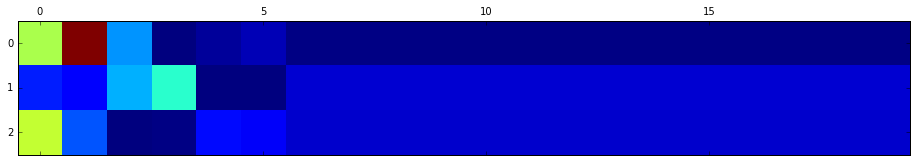

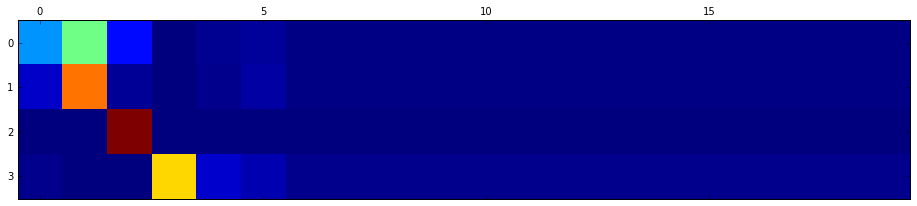

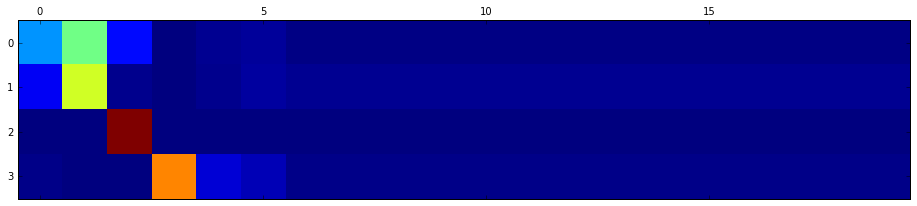

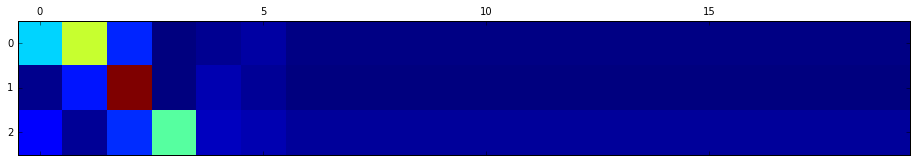

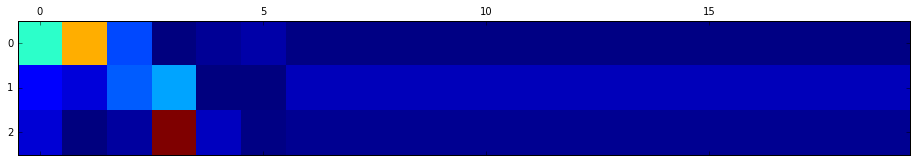

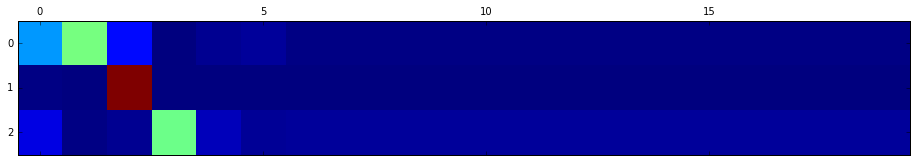

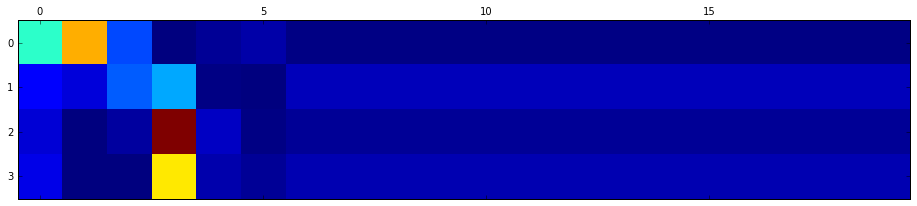

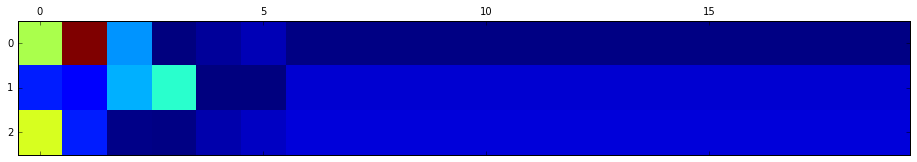

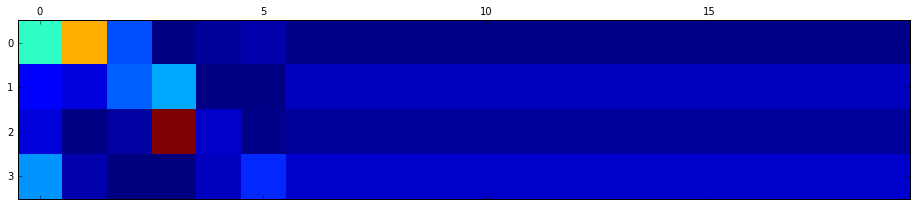

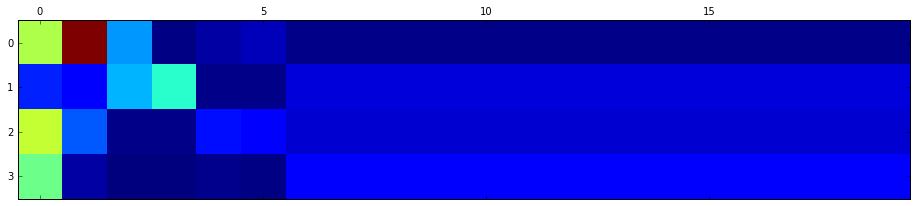

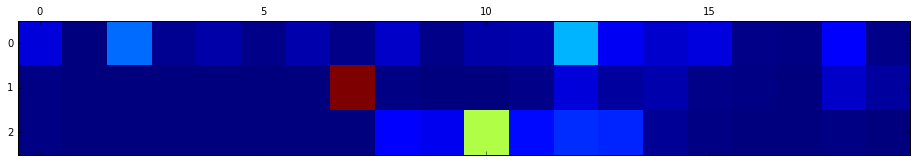

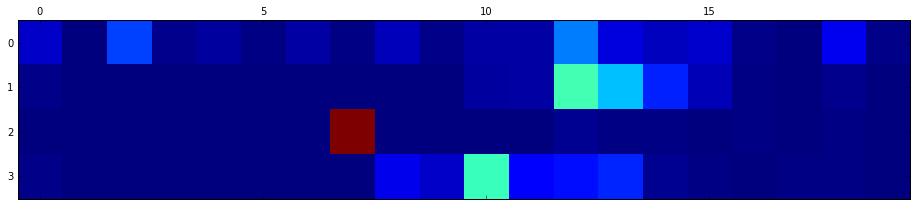

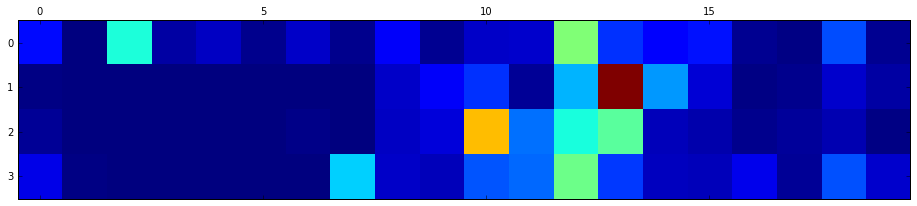

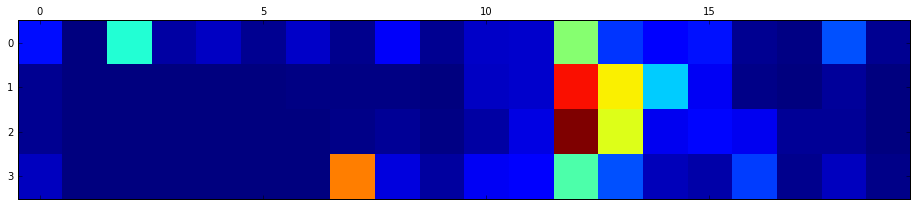

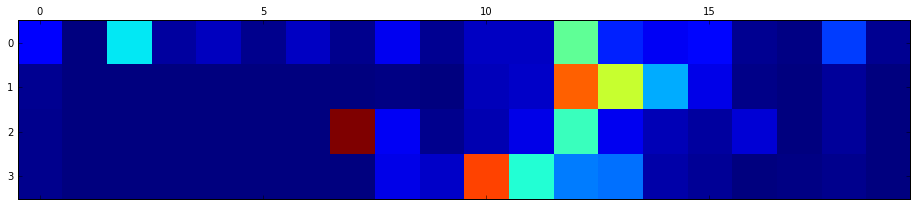

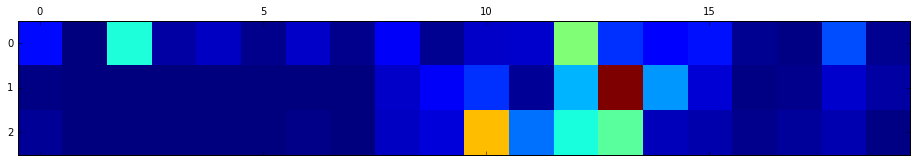

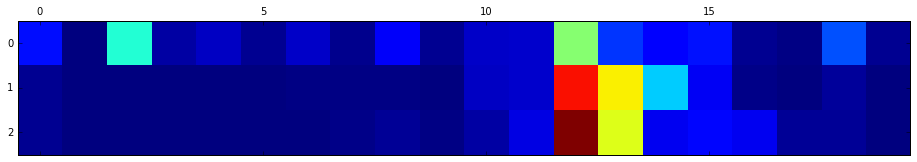

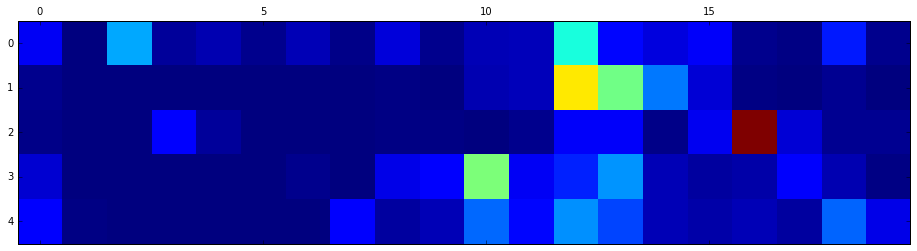

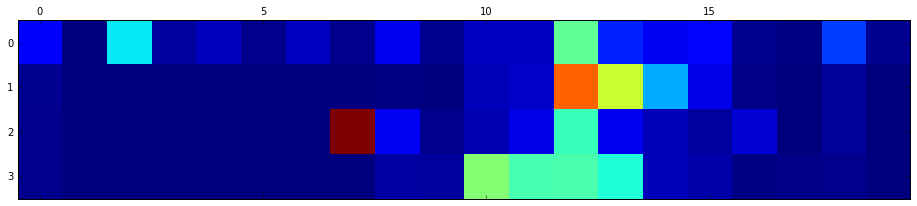

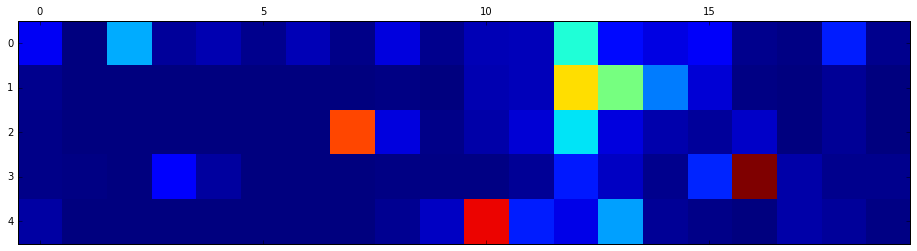

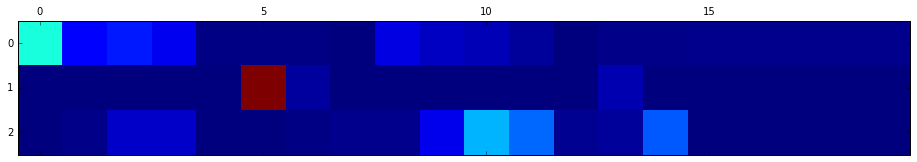

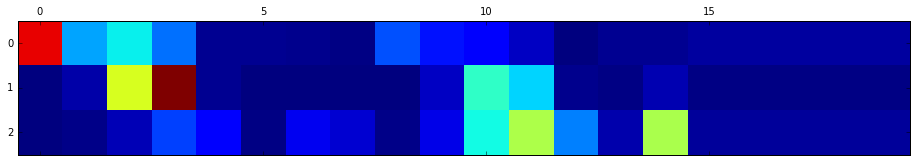

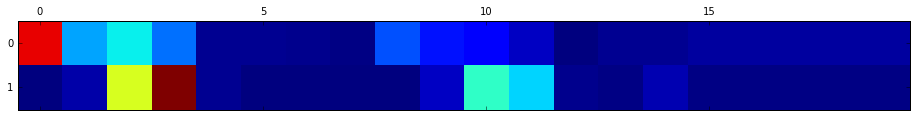

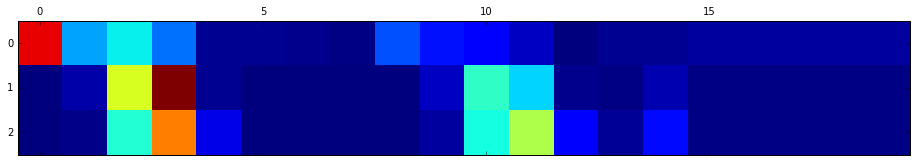

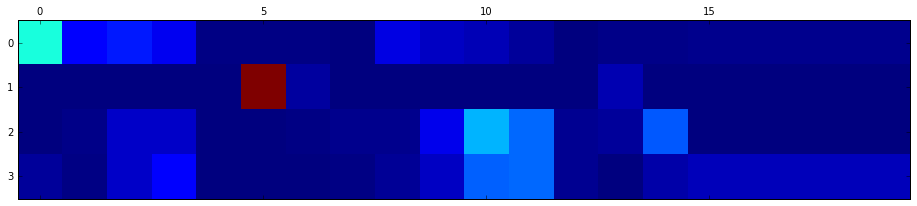

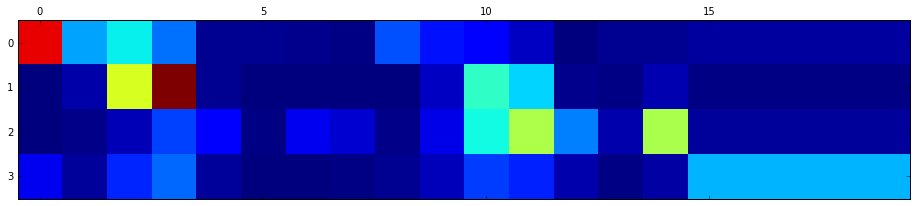

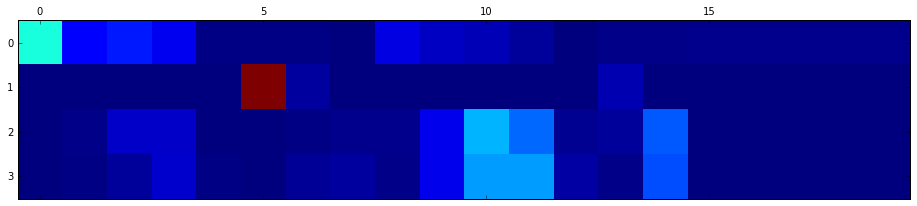

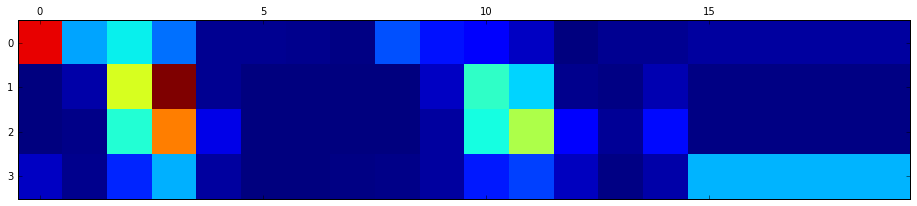

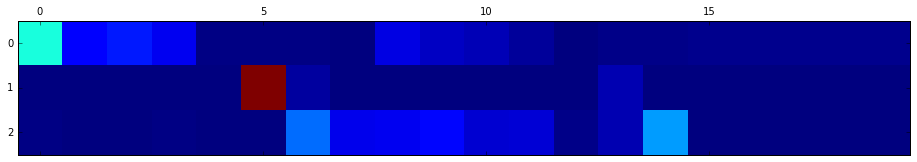

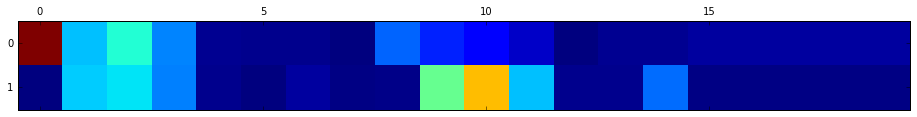

In [12]:
predict(predictor, "宝宝太胖怎么办呢")
predict(predictor, "包邮买二送一性感女内裤低腰诱惑透视蕾丝露臀大蝴蝶三角内裤女夏-淘宝网")
predict(predictor, "大棚辣椒果实变小怎么办,大棚辣椒果实变小防治措施")
